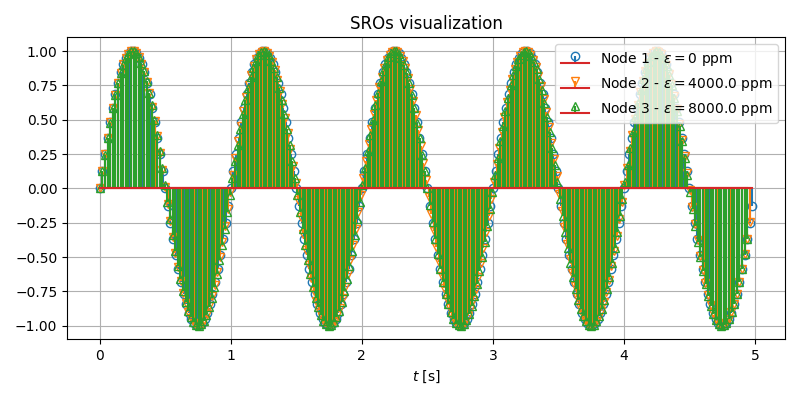

In [1]:
from pathlib import Path, PurePath
import sys
import numpy as np
%matplotlib widget
# Find path to root folder
rootFolder = 'sounds-phd'
pathToRoot = Path().resolve()
while PurePath(pathToRoot).name != rootFolder:
    pathToRoot = pathToRoot.parent
sys.path.append(f'{pathToRoot}/01_algorithms/01_NR/02_distributed')
from danse_utilities.setup import apply_sro

fs = 50                   # sampling frequency [samples/s] (true sampling rate)
dur = 10                    # signal duration [s]
sroppm = 9025                 # SRO [ppm] 
f = 1
nSamples = int(fs * dur)        # total number of samples

t = np.arange(nSamples) / fs
nNodes = 3
x = np.zeros((len(t), nNodes))
for ii in range(nNodes):
    x[:, ii] = np.sin(2 * np.pi * f * t)

sros = [0, 4e3, 8e3] # [ppm]

sensorToNodeTags = np.array([1,2,3])

x_out, t_out = apply_sro(x, fs, sensorToNodeTags, sros, showSRO=True)

In [2]:
# SRO estimation / compensation implementation 

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [6.25000000e-05, 6.25000000e-05, 6.18811881e-05],
       [1.25000000e-04, 1.25000000e-04, 1.23762376e-04],
       [1.87500000e-04, 1.87500000e-04, 1.85643564e-04],
       [2.50000000e-04, 2.50000000e-04, 2.47524752e-04],
       [3.12500000e-04, 3.12500000e-04, 3.09405941e-04],
       [3.75000000e-04, 3.75000000e-04, 3.71287129e-04],
       [4.37500000e-04, 4.37500000e-04, 4.33168317e-04],
       [5.00000000e-04, 5.00000000e-04, 4.95049505e-04],
       [5.62500000e-04, 5.62500000e-04, 5.56930693e-04],
       [6.25000000e-04, 6.25000000e-04, 6.18811881e-04],
       [6.87500000e-04, 6.87500000e-04, 6.80693069e-04],
       [7.50000000e-04, 7.50000000e-04, 7.42574257e-04],
       [8.12500000e-04, 8.12500000e-04, 8.04455446e-04],
       [8.75000000e-04, 8.75000000e-04, 8.66336634e-04],
       [9.37500000e-04, 9.37500000e-04, 9.28217822e-04],
       [1.00000000e-03, 1.00000000e-03, 9.90099010e-04],
       [1.06250000e-03, 1.06250